## Libraries Preparation

In [1]:
# import libraries
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
import string
from collections import Counter
import sklearn.metrics as sk_metrics
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.spatial.distance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gmaps

## Seattle Parks and Recreational Data - Trails

In [2]:
# read-in data
trails = pd.read_csv('Trails.csv')
# filter out the trail related attributes of interest
trails1 = trails[['PMA_NAME','TRAIL_ID','PMAID','TRAIL_NUM',
                 'SURFACE_TY','CONDITION','WIDTH','CANOPY','GRADE_TYPE',
                 'GRADE_PERC','SHAPE_LENG']]
# sort the table by:
# 1)'PMAID--Park ID' and
# 2)'TRAIL_NUM--Individual ID for each trail in the park'
trails1 = trails1.sort_values(['PMAID','TRAIL_NUM'])

# Rename some column names
trails1 = trails1.rename(columns = {'TRAIL_ID':'ID','PMAID':'Park_ID',
                         'TRAIL_NUM':'Trail_ID'})

# Get a copy of trails1, just in case need it later
trails2 = trails1


In [3]:
# variables summary -- numerical variables
trails1.describe()

,Park_ID,Trail_ID,WIDTH,GRADE_PERC,SHAPE_LENG
count,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000
mean,694.674543,70.637576,4.240473,4.714177,279.526783
std,1043.401338,79.578005,3.244002,2.862967,348.290888
min,234.000000,1.000000,1.000000,0.000000,2.516281
25%,310.000000,13.000000,3.000000,3.000000,88.488818
50%,398.000000,40.000000,4.000000,5.000000,177.547869
75%,460.000000,103.000000,5.000000,7.000000,344.705812
max,4479.000000,391.000000,103.000000,20.000000,4584.924501


In [4]:
# dataframe summary, including those categorical variables
trails1.astype('object').describe().transpose()

,count,unique,top,freq
PMA_NAME,2624,71,DISCOVERY PARK,245
ID,2624,2597,404-11,3
Park_ID,2624,65,310,245
Trail_ID,2624,326,2,59
SURFACE_TY,2624,10,Gravel,1213
CONDITION,2624,5,Good,1443
WIDTH,2624,18,4,603
CANOPY,2624,4,Open,1224
GRADE_TYPE,2624,4,Gradual,986
GRADE_PERC,2624,15,3,463


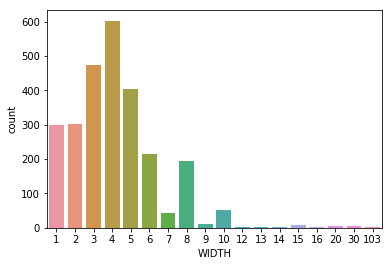

In [5]:
# countplot for the 'WIDTH' variable
# check for outlier 
# (regard the given trail width values as discrete)
sns.countplot(x='WIDTH', data = trails1) # note the '103' 

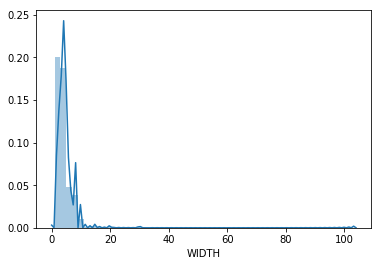

In [6]:
# bar plot for the 'WIDTH' variable
# (regard the given trail width values as continuous)
sns.distplot(trails1['WIDTH']) # note the long tail in the distribution

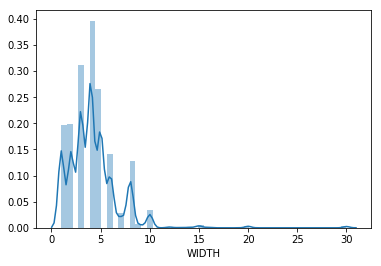

In [7]:
# observation with WIDTH = 103 might be outlier
# remove outlier observation from the dataframe
trails1 = trails1.query('WIDTH != 103')

# check the bar plot again to make sure WIDTH = 103 is removed
sns.distplot(trails1['WIDTH'])

## Data Preprocessing and PCA

### Prepare Ordinal Variables

In [8]:
# Check 'GRADE_TYPE' levels and transform to ordinal numbers
trails1['GRADE_TYPE'].unique()

array(['Steep', 'Gradual', 'Flat', 'Moderate'], dtype=object)

In [9]:
# Create a mapper as transformation reference using dictionary
# Flat - 1, gradual - 2, moderate - 3, steep - 4
mapper_gtype = {'Flat': 1, 'Gradual': 2, 'Moderate': 3, 'Steep': 4}
# replace the categorical levels with the ordinal levels
trails1.loc[:,'GRADE_TYPE'] = trails1['GRADE_TYPE'].replace(mapper_gtype)

D:\Anaconda\Install\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
# Check 'CANOPY' categories and transform to ordinal levels
trails1['CANOPY'].unique()

array(['Low', 'High', 'Open', 'Closed'], dtype=object)

In [11]:
# Create the reference mapper
# Open - 1, Low - 2, High - 3, Closed (means very high) - 4
mapper_canopy = {'Open': 1, 'Low': 2, 'High': 3, 'Closed': 4}
# replace the canopy categories with the ordinal levels
trails1.loc[:,'CANOPY'] = trails1['CANOPY'].replace(mapper_canopy)

In [12]:
# Check 'CONDITION' categories and transform to ordinal levels
trails1['CONDITION'].unique()

array(['Worn', 'Good', 'Eroded', 'Poor', 'Overgrown'], dtype=object)

In [13]:
# Create the reference mapper
# Worn and Eroded - 1, Poor - 2, Overgrown - 3, Good - 4
mapper_condi = {'Worn': 1, 'Eroded': 1, 'Poor': 2, 
                'Overgrown': 3, 'Good': 4}
# replace the condition categories with the ordinal levels
trails1.loc[:,'CONDITION'] = trails1['CONDITION'].replace(mapper_condi)

In [14]:
# Check 'SURFACE_TY' but found no explicit clue for giving different
# surface type an order and transform them into a Likert Scale
trails1['SURFACE_TY'].unique()

array(['Gravel', 'Bridge', 'Stairs', 'Soil', 'Concrete', 'Boardwalk',
       'Asphalt', 'Check Steps', 'Bark', 'Grass'], dtype=object)

### Surface Type Classificaiton - Vector Space Modeling

I decided to utilize text mining to group these surface types into clusters and give an intuitive explanation about the groupings.


In [15]:
# Code modified from the one given by instructor
# Since I could not find a good description document on the grass-type 
# trail so I would intuitively group it with soil

asphalt = open('asphalt.txt').read().split()
bark = open('bark.txt').read().split()
bridge = open('bridge.txt').read().split()
broadwalk = open('broadwalk.txt').read().split()
check_step = open('check_step.txt').read().split()
concrete = open('concrete.txt').read().split()
gravel = open('gravel.txt').read().split()
soil = open('soil.txt').read().split()
step = open('step.txt').read().split()


In [16]:
# Stop words to be removed:
# Remove common stop words as well as surface type names
# mentioned in the texts
# Reasons for removing surface type names:
# 1) Lots of documents seem to compare specific surface types
# 2) I am more interested in using surface type properties
# to classify these surface types rather than using their names.

stop_words = ["the", "The", "of", "it", "A", "a", "and", "to", "or",
             "in", "on", "by", "as", "if", "for", "is", "are", "It", 
             "from", "that", "be", "do", "also", "an", "An", "with",
             "asphalt", "bark", "bridge", "broadwalk", "step",
             "concrete", "gravel", "soil"]

In [17]:
# define a function to clean the input text file
def clean(text):
    # remove stop words
    text = [i for i in text if i not in stop_words]
    # remove punctuations
    punc_mapping_tab = str.maketrans('','', string.punctuation)
    text = [j.translate(punc_mapping_tab) for j in text]
    # remove digits
    dig_mapping_tab = str.maketrans('','', string.digits)
    text = [k.translate(dig_mapping_tab) for k in text]
    # remove empty strings
    text = list(filter(None, text))
    # convert each word in the list to lowercase
    text = [l.lower() for l in text]
    return text

In [18]:
# clean the text files by calling the 'clean()' function defined above
asphalt = clean(asphalt)
bark = clean(bark)
bridge = clean(bridge)
broadwalk = clean(broadwalk)
check_step = clean(check_step)
concrete = clean(concrete)
gravel = clean(gravel)
soil = clean(soil)
step = clean(step)

In [19]:
# combine all the text together into one list
terms = asphalt+bark+bridge+broadwalk+check_step+concrete+gravel+soil+step
# keep the unique words
terms = list(set(terms))
# the number of terms
nterms = len(terms)
# number of text documents
nds = 9

In [20]:
# get occurrence frequency of each term in each document
def get_count(text):
    cnt = [0] * nterms # will hold the coutns
    for i in range(nterms):
        for t in text:
            if t == terms[i]:
                cnt[i] = cnt[i] + 1
                
    return cnt


In [21]:
# term frequency values (the number of times a term appears in a document)
tf_asphalt = pd.Series(get_count(asphalt))
tf_bark = pd.Series(get_count(bark))
tf_bridge = pd.Series(get_count(bridge))
tf_broadwalk = pd.Series(get_count(broadwalk))
tf_checkstep = pd.Series(get_count(check_step))
tf_concrete = pd.Series(get_count(concrete))
tf_gravel = pd.Series(get_count(gravel))
tf_soil = pd.Series(get_count(soil))
tf_step = pd.Series(get_count(step))


In [22]:
# column bind all the count results after scanning through each unique term
tfs = pd.concat([tf_asphalt,tf_bark,tf_bridge,tf_broadwalk,
                tf_checkstep,tf_concrete,tf_gravel,tf_soil,
                tf_step],axis = 1)

# rename the dataframe columns with the surface type names
surf_types = ['asphalt', 'bark', 'bridge', 'broadwalk',
              'check_step', 'concrete', 'gravel', 'soil',
              'stairs']
tfs.columns = surf_types

# rename the dataframe rows or indices with the unique terms from documents
tfs.index = terms


In [23]:
# summary about the document term frequency values
# (the number of documents that contain that specific term)
dfs = tfs.apply(lambda x: sum(x>0), axis = 1)

# compute the Inverse Document Frequency(idf) values
idf = dfs.apply(lambda x: np.math.log10(nds/x))

In [24]:
# compute the tf-idf weights, term-document matrix
td_mat = tfs.apply(lambda x: x * idf, axis = 0)

In [25]:
# define a function to compute cosine similarity
def cos_simi(x, y):
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    return dot_product / (norm_x * norm_y)


In [26]:
# compute the similarities between all pairs of docs
# first define a matrix to store the similarity values
S_mat = np.zeros((nds,nds))

# populate the S_mat matrix with similarity values
for i in range(nds):
    for j in range(nds):
        x = td_mat.iloc[:,i]
        y = td_mat.iloc[:,j]
        S_mat[i,j] = cos_simi(x,y)

In [27]:
# rename the column names and row(index) names
S_mat = pd.DataFrame(S_mat)
S_mat.columns = surf_types
S_mat.index = surf_types
S_mat

,asphalt,bark,bridge,broadwalk,check_step,concrete,gravel,soil,stairs
asphalt,1.000000,0.046705,0.039863,0.079887,0.036911,0.111420,0.078856,0.019072,0.029601
bark,0.046705,1.000000,0.021552,0.077747,0.023434,0.027365,0.049207,0.008945,0.022084
bridge,0.039863,0.021552,1.000000,0.037604,0.033652,0.034169,0.045272,0.006380,0.025561
broadwalk,0.079887,0.077747,0.037604,1.000000,0.042313,0.074349,0.052570,0.013243,0.034628
check_step,0.036911,0.023434,0.033652,0.042313,1.000000,0.013108,0.040484,0.026754,0.035158
concrete,0.111420,0.027365,0.034169,0.074349,0.013108,1.000000,0.105724,0.024002,0.019198
gravel,0.078856,0.049207,0.045272,0.052570,0.040484,0.105724,1.000000,0.038177,0.041006
soil,0.019072,0.008945,0.006380,0.013243,0.026754,0.024002,0.038177,1.000000,0.012293
stairs,0.029601,0.022084,0.025561,0.034628,0.035158,0.019198,0.041006,0.012293,1.000000


In [28]:
# derive the distance matrix
D_mat = pd.DataFrame(1-S_mat)
D_mat

,asphalt,bark,bridge,broadwalk,check_step,concrete,gravel,soil,stairs
asphalt,0.000000,9.532949e-01,0.960137,9.201127e-01,0.963089,8.885799e-01,0.921144,0.980928,9.703986e-01
bark,0.953295,-2.220446e-16,0.978448,9.222533e-01,0.976566,9.726349e-01,0.950793,0.991055,9.779157e-01
bridge,0.960137,9.784480e-01,0.000000,9.623956e-01,0.966348,9.658314e-01,0.954728,0.993620,9.744393e-01
broadwalk,0.920113,9.222533e-01,0.962396,-2.220446e-16,0.957687,9.256506e-01,0.947430,0.986757,9.653721e-01
check_step,0.963089,9.765658e-01,0.966348,9.576873e-01,0.000000,9.868918e-01,0.959516,0.973246,9.648421e-01
concrete,0.888580,9.726349e-01,0.965831,9.256506e-01,0.986892,-2.220446e-16,0.894276,0.975998,9.808016e-01
gravel,0.921144,9.507934e-01,0.954728,9.474303e-01,0.959516,8.942765e-01,0.000000,0.961823,9.589939e-01
soil,0.980928,9.910548e-01,0.993620,9.867570e-01,0.973246,9.759979e-01,0.961823,0.000000,9.877065e-01
stairs,0.970399,9.779157e-01,0.974439,9.653721e-01,0.964842,9.808016e-01,0.958994,0.987707,-2.220446e-16


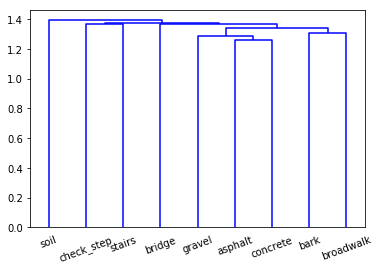

In [29]:
# agglomerative hierarchical clustering using 'average' method
dend_ave = dendrogram(linkage(D_mat, method = 'average'),
                  labels = D_mat.columns,
                  leaf_font_size=10,
                  leaf_rotation=20)

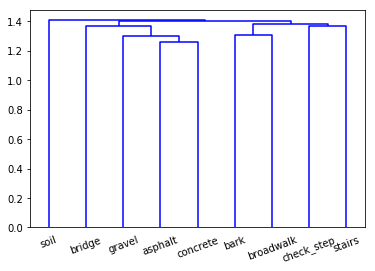

In [30]:
# hierarchical clustering using 'complete' method
dend_comp = dendrogram(linkage(D_mat, method = 'complete'),
                  labels = D_mat.columns,
                  leaf_font_size=10,
                  leaf_rotation=20)

Choose to use complete linkage and the results are:

* Cluster1: Soil, grass (natural earth, soft, cheaper, level of human impact: 1)

* Cluster2: bark, broadwalk, check step, stairs (neutral, relatively soft, smaller constructions, level of human impact: 2)

* Cluster3: bridge, asphalt, concrete, gravel (hard materials, larger constructions, least natural earth to look at, level of human impact: 3)

In [31]:
# Check 'SURFACE_TY' but found no explicit clue for giving different
# surface type an order and transform them into a Likert Scale
trails1['SURFACE_TY'].unique()

array(['Gravel', 'Bridge', 'Stairs', 'Soil', 'Concrete', 'Boardwalk',
       'Asphalt', 'Check Steps', 'Bark', 'Grass'], dtype=object)

In [32]:
# Create the reference mapper
mapper_surf = {'Soil': 1, 'Grass': 1, 'Bark': 2, 'Boardwalk': 2, 
               'Check Steps': 2, 'Stairs': 2, 'Bridge': 3,
               'Asphalt': 3, 'Concrete': 3, 'Gravel': 3}
# replace the condition categories with the ordinal levels
trails1.loc[:,'SURFACE_TY'] = trails1['SURFACE_TY'].replace(mapper_surf)

### PCA

In [33]:
# the features we are going to put into PCA
df_for_pca = trails1.iloc[:,4:11] # 7 features in total

# PCA with 7 principal components
trails_pca = PCA(n_components = 7)
from_pca = trails_pca.fit_transform(StandardScaler().fit_transform(df_for_pca))
# principal component dataframe
df_from_pca = pd.DataFrame(data = from_pca, columns = list(df_for_pca.columns.values))

D:\Anaconda\Install\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\Install\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [34]:
# print out the proportion of variance explained (PVE) by each principal component
print(trails_pca.explained_variance_ratio_)

[0.32761778 0.20417859 0.15609381 0.13709147 0.08357458 0.06984847
 0.02159529]


Text(0, 0.5, 'PVE')

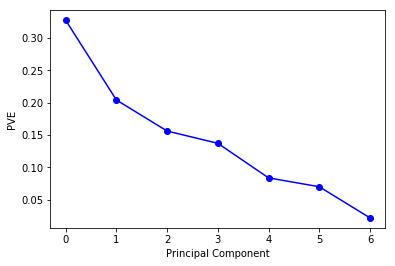

In [35]:
# plot the PVE
plt.plot(trails_pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('PVE')

Text(0, 0.5, 'Cumulative PVE')

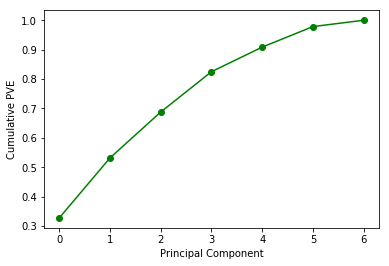

In [36]:
# plot the  Cumulative PVE
plt.plot(trails_pca.explained_variance_ratio_.cumsum(), 'go-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative PVE')

It turned out the first three principal components are adequate to explain about 70% of the variation in the data. Also, note that the first two principal components explain over 50% of the variation.

In [37]:
# output the loading vectors for the first three principal components
pd.DataFrame(trails_pca.components_[0:3].T, index = df_for_pca.columns.values , 
             columns = ['PC1', 'PC2', 'PC3'])

,PC1,PC2,PC3
SURFACE_TY,-0.266415,0.549852,-0.150283
CONDITION,-0.300371,-0.085593,0.698011
WIDTH,-0.247784,0.649377,-0.051060
CANOPY,0.408521,0.075550,-0.498218
GRADE_TYPE,0.555828,0.239027,0.330187
GRADE_PERC,0.537768,0.291296,0.348559
SHAPE_LENG,-0.111242,0.347779,0.094078


In [38]:
# loadings for the first principal component
loading1 = trails_pca.components_[0]
loading2 = trails_pca.components_[1]

# observations after transformation by the loadings
obs1 = from_pca[:,0]
obs2 = from_pca[:,1]

Text(0, 0.5, 'PC2')

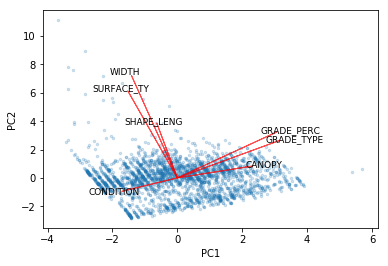

In [39]:
# Visualization of the projections onto biplot
# labels of the features
labels = list(df_for_pca.columns.values)
# plot the arrows with length proportional to loadings for each principal component
for i in range(len(loading1)):
    plt.arrow(0, 0, loading1[i]*max(obs1), loading2[i]*max(obs2),
             color = 'r', alpha = 0.7, width = 0.0005, head_width = 0.0025)
    # text label for each feature
    plt.text(loading1[i]*6.5, loading2[i]*11.5, labels[i], color = 'black', 
             ha = 'center', va = 'center', size =9)
# Scatter plot of the projected observations on the first two principal components
plt.scatter(obs1, obs2, alpha = 0.2, s = 6)
# x and y axes labels
plt.xlabel('PC1', size = 10)
plt.ylabel('PC2', size = 10)

**Findings from the Principal Component Analaysis**:

* GRADE_TYPE and GRADE_PERC –> PC1 –> topographic feature of the trail
* GRADE_TYPE and GRADE_PERC have the largest loading values, 0.56 and 0.54. They are both positive and very close in magnitude. So GRADE_PER should be highly correlated with GRADE_TYPE. Observations(trail segments) with higher PC1 scores tend to have higher GRADE_TYPE or GRADE_PERC values (in other words, steeper).

* SURFACE TYPE, WIDTH and SHAPE_LENGTH –> PC2 –> initial trail setup
* SURFACE TYPE and WIDTH have the largest loadings, 0.55 and 0.65. They are both positive and a little bit off in magnitude. But they are relatively more correlated with each other than with other variables. Trail segments with higher PC2 scores tend to have ‘higher’ surface type value (harder materials, more expensive and greater human impact) and larger width. SHAPE_LENGTH’s loading value is around 0.35 which is not very close to the ones for surface type and width. So I deem it not very important.

* CONDITION and CANOPY – PC3 – trail usage and maintenance (still think important)
* CONDITION and CANOPY have the largest loadings in magnitude, 0.70 (-0.698) and 0.50 (0.498). However, they have opposite signs. Thus, these variables are negatively correlated with each other. Trail segments with higher PC3 scores tend to have ‘higher’ canopy values (more tree canopies) and ‘lower’ condition values (worse trail condition).


## Representative Trail Features and Park Clusters
### Representative Trail Features
Try to find parks with similar trail features and form a new dataset for plot and clustering.

In [40]:
# decide trail 'surface type' for each park by the maximum total shape length
trails_surf0 = trails1.groupby(['PMA_NAME', 'SURFACE_TY'], as_index=False)['SHAPE_LENG'].agg({'TOT_LENG':'sum'})
trails_surf1 = trails_surf0.groupby('PMA_NAME', as_index=False)['TOT_LENG'].agg({'MAX_LENG':'max'})
trails_surf = pd.merge(trails_surf0, trails_surf1, on='PMA_NAME')
trails_surf = trails_surf[trails_surf['TOT_LENG'] == trails_surf['MAX_LENG']].reset_index(drop=True)

In [41]:
# decide trail 'condition' for each park by the maximum total shape length
trails_cond0 = trails1.groupby(['PMA_NAME', 'CONDITION'], as_index=False)['SHAPE_LENG'].agg({'TOT_LENG':'sum'})
trails_cond1 = trails_cond0.groupby('PMA_NAME', as_index=False)['TOT_LENG'].agg({'MAX_LENG':'max'})
trails_cond = pd.merge(trails_cond0, trails_cond1, on='PMA_NAME')
trails_cond = trails_cond[trails_cond['TOT_LENG'] == trails_cond['MAX_LENG']].reset_index(drop=True)

In [42]:
# decide trail 'width' for each park by maximum total shape length
trails_width0 = trails1.groupby(['PMA_NAME', 'WIDTH'], as_index=False)['SHAPE_LENG'].agg({'TOT_LENG':'sum'})
trails_width1 = trails_width0.groupby('PMA_NAME', as_index=False)['TOT_LENG'].agg({'MAX_LENG':'max'})
trails_width = pd.merge(trails_width0, trails_width1, on='PMA_NAME')
trails_width = trails_width[trails_width['TOT_LENG'] == trails_width['MAX_LENG']].reset_index(drop=True)

In [43]:
# decide trail 'canopy' type for each park by maximum total shape length
trails_canopy0 = trails1.groupby(['PMA_NAME', 'CANOPY'], as_index=False)['SHAPE_LENG'].agg({'TOT_LENG':'sum'})
trails_canopy1 = trails_canopy0.groupby('PMA_NAME', as_index=False)['TOT_LENG'].agg({'MAX_LENG':'max'})
trails_canopy = pd.merge(trails_canopy0, trails_canopy1, on='PMA_NAME')
trails_canopy = trails_canopy[trails_canopy['TOT_LENG'] == trails_canopy['MAX_LENG']].reset_index(drop=True)

In [44]:
# decide trail 'grade_type' for each park by maximum total shape length
trails_grade0 = trails1.groupby(['PMA_NAME', 'GRADE_TYPE'], as_index=False)['SHAPE_LENG'].agg({'TOT_LENG':'sum'})
trails_grade1 = trails_grade0.groupby('PMA_NAME', as_index=False)['TOT_LENG'].agg({'MAX_LENG':'max'})
trails_grade = pd.merge(trails_grade0, trails_grade1, on='PMA_NAME')
trails_grade = trails_grade[trails_grade['TOT_LENG'] == trails_grade['MAX_LENG']].reset_index(drop=True)

In [45]:
# total length of trails in each park
trails_length = trails1.groupby('PMA_NAME', as_index=False)['SHAPE_LENG'].agg({'TOT_LENG':'sum'}).reset_index(drop=True)

In [46]:
# decide trail 'grade_perc' for each park by maximum total shape length
trails_perc0 = trails1.groupby(['PMA_NAME', 'GRADE_PERC'], as_index=False)['SHAPE_LENG'].agg({'TOT_LENG':'sum'})
trails_perc1 = trails_perc0.groupby('PMA_NAME', as_index=False)['TOT_LENG'].agg({'MAX_LENG':'max'})
trails_perc = pd.merge(trails_perc0, trails_perc1, on='PMA_NAME')
trails_perc = trails_perc[trails_perc['TOT_LENG'] == trails_perc['MAX_LENG']].reset_index(drop=True)

### Park Clusters

In [47]:
# Form the trails3 dataframe for clustering the parks
trails3 = pd.concat([trails_surf[['PMA_NAME','SURFACE_TY']], trails_cond['CONDITION'],
                    trails_width['WIDTH'], trails_canopy['CANOPY'], trails_grade['GRADE_TYPE'],
                    trails_perc['GRADE_PERC'], trails_length['TOT_LENG']], axis = 1)

In [48]:
# view the first 6 rows (parks)
trails3.head()

,PMA_NAME,SURFACE_TY,CONDITION,WIDTH,CANOPY,GRADE_TYPE,GRADE_PERC,TOT_LENG
0,BHY KRACKE PARK,3,4,3,1,3,9,1480.812285
1,BOREN PARK,1,1,3,3,4,10,2177.787564
2,CAMP LONG,3,1,4,3,2,4,19582.913129
3,CARKEEK PARK,3,1,4,3,3,7,34851.762358
4,CEDAR PARK,3,4,5,1,1,3,1189.197911


In [49]:
# replace the indices by the park names
trails3.index = list(trails3['PMA_NAME'])
# remove the park-name ('PMA_NAME') column in the data frame
trails3 = trails3.drop(columns='PMA_NAME')

In [50]:
# check the 'trails3' data frame
trails3.head()

,SURFACE_TY,CONDITION,WIDTH,CANOPY,GRADE_TYPE,GRADE_PERC,TOT_LENG
BHY KRACKE PARK,3,4,3,1,3,9,1480.812285
BOREN PARK,1,1,3,3,4,10,2177.787564
CAMP LONG,3,1,4,3,2,4,19582.913129
CARKEEK PARK,3,1,4,3,3,7,34851.762358
CEDAR PARK,3,4,5,1,1,3,1189.197911


In [51]:
# compute the similarities between all pairs of parks

# store the number of rows (total number of parks)
npk = trails3.shape[0]

# first define a matrix to store the similarity values
S_park = np.zeros((npk,npk))

# populate the S_mat matrix with similarity values
for i in range(npk):
    for j in range(npk):
        x = trails3.iloc[i,:]
        y = trails3.iloc[j,:]
        S_park[i,j] = cos_simi(x,y)

In [52]:
# rename the column names and row(index) names
S_park = pd.DataFrame(S_park)
S_park.columns = list(trails3.index)
S_park.index = list(trails3.index)
S_park

,BHY KRACKE PARK,BOREN PARK,CAMP LONG,CARKEEK PARK,CEDAR PARK,CHEASTY GREENSPACE,CHEASTY GREENSPACE: MT VIEW,CHEASTY GS: CHEASTY BLVD,COLMAN PARK,COWEN PARK,...,THORNTON CREEK PARK #2,THORTON CREEK PARK #6,VOLUNTEER PARK,WARREN G. MAGNUSON PARK,WASHINGTON PARK AND ARBORETUM,WEST DUWAMISH GREENBELT,WEST DUWAMISH GS: PUGET PARK,WEST DUWAMISH GS: RIVERVIEW,WESTCREST PARK,WOODLAND PARK
BHY KRACKE PARK,1.000000,0.999995,0.999974,0.999973,0.999990,0.999981,0.999992,0.999981,0.999975,0.999983,...,0.999987,0.999987,0.999975,0.999972,0.999973,0.999955,0.999982,0.999981,0.999973,0.999976
BOREN PARK,0.999995,1.000000,0.999987,0.999987,0.999987,0.999989,0.999996,0.999991,0.999988,0.999991,...,0.999987,0.999995,0.999988,0.999986,0.999986,0.999949,0.999993,0.999992,0.999987,0.999989
CAMP LONG,0.999974,0.999987,1.000000,1.000000,0.999981,0.999998,0.999992,0.999999,1.000000,0.999997,...,0.999957,0.999997,1.000000,1.000000,1.000000,0.999895,0.999999,0.999999,1.000000,1.000000
CARKEEK PARK,0.999973,0.999987,1.000000,1.000000,0.999980,0.999998,0.999991,0.999999,1.000000,0.999996,...,0.999956,0.999997,1.000000,1.000000,1.000000,0.999894,0.999999,0.999999,1.000000,1.000000
CEDAR PARK,0.999990,0.999987,0.999981,0.999980,1.000000,0.999987,0.999994,0.999985,0.999983,0.999993,...,0.999978,0.999990,0.999981,0.999979,0.999980,0.999928,0.999983,0.999984,0.999979,0.999982
CHEASTY GREENSPACE,0.999981,0.999989,0.999998,0.999998,0.999987,1.000000,0.999996,0.999999,0.999998,0.999998,...,0.999965,0.999997,0.999998,0.999997,0.999998,0.999907,0.999998,0.999998,0.999998,0.999998
CHEASTY GREENSPACE: MT VIEW,0.999992,0.999996,0.999992,0.999991,0.999994,0.999996,1.000000,0.999995,0.999993,0.999996,...,0.999983,0.999998,0.999992,0.999991,0.999991,0.999939,0.999995,0.999995,0.999991,0.999992
CHEASTY GS: CHEASTY BLVD,0.999981,0.999991,0.999999,0.999999,0.999985,0.999999,0.999995,1.000000,1.000000,0.999998,...,0.999964,0.999999,1.000000,0.999999,0.999999,0.999907,1.000000,1.000000,0.999999,1.000000
COLMAN PARK,0.999975,0.999988,1.000000,1.000000,0.999983,0.999998,0.999993,1.000000,1.000000,0.999997,...,0.999958,0.999997,1.000000,1.000000,1.000000,0.999896,0.999999,0.999999,1.000000,1.000000
COWEN PARK,0.999983,0.999991,0.999997,0.999996,0.999993,0.999998,0.999996,0.999998,0.999997,1.000000,...,0.999969,0.999998,0.999997,0.999996,0.999996,0.999909,0.999997,0.999998,0.999996,0.999997


In [53]:
# derive the distance matrix
D_park = pd.DataFrame(1-S_park)
D_park

,BHY KRACKE PARK,BOREN PARK,CAMP LONG,CARKEEK PARK,CEDAR PARK,CHEASTY GREENSPACE,CHEASTY GREENSPACE: MT VIEW,CHEASTY GS: CHEASTY BLVD,COLMAN PARK,COWEN PARK,...,THORNTON CREEK PARK #2,THORTON CREEK PARK #6,VOLUNTEER PARK,WARREN G. MAGNUSON PARK,WASHINGTON PARK AND ARBORETUM,WEST DUWAMISH GREENBELT,WEST DUWAMISH GS: PUGET PARK,WEST DUWAMISH GS: RIVERVIEW,WESTCREST PARK,WOODLAND PARK
BHY KRACKE PARK,2.220446e-16,5.319019e-06,2.615896e-05,2.660177e-05,0.000010,1.927576e-05,8.284909e-06,1.945730e-05,2.457729e-05,1.676027e-05,...,0.000013,1.322323e-05,2.484088e-05,2.805734e-05,2.726105e-05,0.000045,1.825652e-05,1.937022e-05,2.722319e-05,2.398923e-05
BOREN PARK,5.319019e-06,2.220446e-16,1.269736e-05,1.296589e-05,0.000013,1.050248e-05,4.174802e-06,8.678189e-06,1.240467e-05,9.105213e-06,...,0.000013,4.549404e-06,1.216247e-05,1.412470e-05,1.358544e-05,0.000051,6.725474e-06,7.814807e-06,1.340037e-05,1.133832e-05
CAMP LONG,2.615896e-05,1.269736e-05,0.000000e+00,8.893466e-09,0.000019,2.226527e-06,8.328333e-06,5.343396e-07,1.007030e-07,3.274784e-06,...,0.000043,3.051145e-06,3.488870e-08,4.676182e-08,2.746305e-08,0.000105,1.073697e-06,6.133896e-07,2.309935e-08,7.481267e-08
CARKEEK PARK,2.660177e-05,1.296589e-05,8.893466e-09,0.000000e+00,0.000020,2.349976e-06,8.726501e-06,6.147234e-07,1.388145e-07,3.557383e-06,...,0.000044,3.297214e-06,4.563092e-08,2.706813e-08,1.001845e-08,0.000106,1.121944e-06,6.897467e-07,6.755943e-09,8.729685e-08
CEDAR PARK,9.750400e-06,1.312274e-05,1.949112e-05,2.015703e-05,0.000000,1.303748e-05,6.179433e-06,1.476394e-05,1.736203e-05,7.362541e-06,...,0.000022,1.041291e-05,1.851445e-05,2.086372e-05,2.047519e-05,0.000072,1.673468e-05,1.568234e-05,2.069880e-05,1.810271e-05
CHEASTY GREENSPACE,1.927576e-05,1.050248e-05,2.226527e-06,2.349976e-06,0.000013,-2.220446e-16,4.178846e-06,1.336581e-06,1.597904e-06,2.304963e-06,...,0.000035,2.833899e-06,1.862657e-06,2.521124e-06,2.382931e-06,0.000093,2.280445e-06,2.006915e-06,2.434547e-06,1.909387e-06
CHEASTY GREENSPACE: MT VIEW,8.284909e-06,4.174802e-06,8.328333e-06,8.726501e-06,0.000006,4.178846e-06,2.220446e-16,4.883441e-06,7.338405e-06,3.813353e-06,...,0.000017,2.024824e-06,7.767879e-06,9.477713e-06,9.100044e-06,0.000061,4.998410e-06,5.167254e-06,9.007447e-06,7.515732e-06
CHEASTY GS: CHEASTY BLVD,1.945730e-05,8.678189e-06,5.343396e-07,6.147234e-07,0.000015,1.336581e-06,4.883441e-06,0.000000e+00,3.612822e-07,2.022333e-06,...,0.000036,1.297272e-06,3.766114e-07,8.447386e-07,7.178282e-07,0.000093,3.479867e-07,1.247342e-07,6.999993e-07,3.168866e-07
COLMAN PARK,2.457729e-05,1.240467e-05,1.007030e-07,1.388145e-07,0.000017,1.597904e-06,7.338405e-06,3.612822e-07,0.000000e+00,2.561847e-06,...,0.000042,2.744997e-06,4.100970e-08,1.792146e-07,1.432009e-07,0.000104,1.135860e-06,6.149278e-07,1.678469e-07,1.026259e-07
COWEN PARK,1.676027e-05,9.105213e-06,3.274784e-06,3.557383e-06,0.000007,2.304963e-06,3.813353e-06,2.022333e-06,2.561847e-06,0.000000e+00,...,0.000031,1.878220e-06,2.987890e-06,3.807397e-06,3.688445e-06,0.000091,3.248903e-06,2.341440e-06,3.811549e-06,2.779818e-06


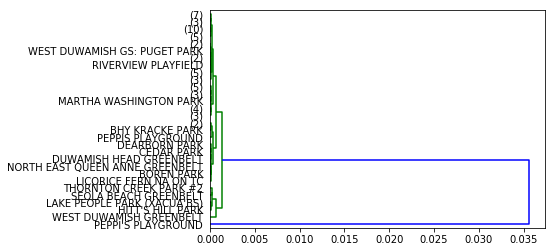

In [54]:
# agglomerative hierarchical clustering using 'complete' method
dend_park1 = dendrogram(linkage(D_park, method = 'complete'),
                  labels = D_park.columns,
                  leaf_font_size=10,
                  truncate_mode='lastp',
                  orientation='right')

In [55]:
# PEPPI'S PLAYGROUND is isolated from the rest
# difficult to see other clusters
# so remove PEPPI'S PLAYGROUND
trails4 = trails3.drop(index = "PEPPI'S PLAYGROUND")

In [56]:
# store the number of rows (total number of parks)
npk1 = trails3.shape[0]-1

# first define a matrix to store the similarity values
S_park1 = np.zeros((npk1,npk1))

# populate the S_mat matrix with similarity values
for i in range(npk1):
    for j in range(npk1):
        x = trails4.iloc[i,:]
        y = trails4.iloc[j,:]
        S_park1[i,j] = cos_simi(x,y)
        
# rename the column names and row(index) names
S_park1 = pd.DataFrame(S_park1)
S_park1.columns = list(trails4.index)
S_park1.index = list(trails4.index)
S_park1

,BHY KRACKE PARK,BOREN PARK,CAMP LONG,CARKEEK PARK,CEDAR PARK,CHEASTY GREENSPACE,CHEASTY GREENSPACE: MT VIEW,CHEASTY GS: CHEASTY BLVD,COLMAN PARK,COWEN PARK,...,THORNTON CREEK PARK #2,THORTON CREEK PARK #6,VOLUNTEER PARK,WARREN G. MAGNUSON PARK,WASHINGTON PARK AND ARBORETUM,WEST DUWAMISH GREENBELT,WEST DUWAMISH GS: PUGET PARK,WEST DUWAMISH GS: RIVERVIEW,WESTCREST PARK,WOODLAND PARK
BHY KRACKE PARK,1.000000,0.999995,0.999974,0.999973,0.999990,0.999981,0.999992,0.999981,0.999975,0.999983,...,0.999987,0.999987,0.999975,0.999972,0.999973,0.999955,0.999982,0.999981,0.999973,0.999976
BOREN PARK,0.999995,1.000000,0.999987,0.999987,0.999987,0.999989,0.999996,0.999991,0.999988,0.999991,...,0.999987,0.999995,0.999988,0.999986,0.999986,0.999949,0.999993,0.999992,0.999987,0.999989
CAMP LONG,0.999974,0.999987,1.000000,1.000000,0.999981,0.999998,0.999992,0.999999,1.000000,0.999997,...,0.999957,0.999997,1.000000,1.000000,1.000000,0.999895,0.999999,0.999999,1.000000,1.000000
CARKEEK PARK,0.999973,0.999987,1.000000,1.000000,0.999980,0.999998,0.999991,0.999999,1.000000,0.999996,...,0.999956,0.999997,1.000000,1.000000,1.000000,0.999894,0.999999,0.999999,1.000000,1.000000
CEDAR PARK,0.999990,0.999987,0.999981,0.999980,1.000000,0.999987,0.999994,0.999985,0.999983,0.999993,...,0.999978,0.999990,0.999981,0.999979,0.999980,0.999928,0.999983,0.999984,0.999979,0.999982
CHEASTY GREENSPACE,0.999981,0.999989,0.999998,0.999998,0.999987,1.000000,0.999996,0.999999,0.999998,0.999998,...,0.999965,0.999997,0.999998,0.999997,0.999998,0.999907,0.999998,0.999998,0.999998,0.999998
CHEASTY GREENSPACE: MT VIEW,0.999992,0.999996,0.999992,0.999991,0.999994,0.999996,1.000000,0.999995,0.999993,0.999996,...,0.999983,0.999998,0.999992,0.999991,0.999991,0.999939,0.999995,0.999995,0.999991,0.999992
CHEASTY GS: CHEASTY BLVD,0.999981,0.999991,0.999999,0.999999,0.999985,0.999999,0.999995,1.000000,1.000000,0.999998,...,0.999964,0.999999,1.000000,0.999999,0.999999,0.999907,1.000000,1.000000,0.999999,1.000000
COLMAN PARK,0.999975,0.999988,1.000000,1.000000,0.999983,0.999998,0.999993,1.000000,1.000000,0.999997,...,0.999958,0.999997,1.000000,1.000000,1.000000,0.999896,0.999999,0.999999,1.000000,1.000000
COWEN PARK,0.999983,0.999991,0.999997,0.999996,0.999993,0.999998,0.999996,0.999998,0.999997,1.000000,...,0.999969,0.999998,0.999997,0.999996,0.999996,0.999909,0.999997,0.999998,0.999996,0.999997


In [57]:
# derive the distance matrix
D_park1 = pd.DataFrame(1-S_park1)
D_park1

,BHY KRACKE PARK,BOREN PARK,CAMP LONG,CARKEEK PARK,CEDAR PARK,CHEASTY GREENSPACE,CHEASTY GREENSPACE: MT VIEW,CHEASTY GS: CHEASTY BLVD,COLMAN PARK,COWEN PARK,...,THORNTON CREEK PARK #2,THORTON CREEK PARK #6,VOLUNTEER PARK,WARREN G. MAGNUSON PARK,WASHINGTON PARK AND ARBORETUM,WEST DUWAMISH GREENBELT,WEST DUWAMISH GS: PUGET PARK,WEST DUWAMISH GS: RIVERVIEW,WESTCREST PARK,WOODLAND PARK
BHY KRACKE PARK,2.220446e-16,5.319019e-06,2.615896e-05,2.660177e-05,0.000010,1.927576e-05,8.284909e-06,1.945730e-05,2.457729e-05,1.676027e-05,...,0.000013,1.322323e-05,2.484088e-05,2.805734e-05,2.726105e-05,0.000045,1.825652e-05,1.937022e-05,2.722319e-05,2.398923e-05
BOREN PARK,5.319019e-06,2.220446e-16,1.269736e-05,1.296589e-05,0.000013,1.050248e-05,4.174802e-06,8.678189e-06,1.240467e-05,9.105213e-06,...,0.000013,4.549404e-06,1.216247e-05,1.412470e-05,1.358544e-05,0.000051,6.725474e-06,7.814807e-06,1.340037e-05,1.133832e-05
CAMP LONG,2.615896e-05,1.269736e-05,0.000000e+00,8.893466e-09,0.000019,2.226527e-06,8.328333e-06,5.343396e-07,1.007030e-07,3.274784e-06,...,0.000043,3.051145e-06,3.488870e-08,4.676182e-08,2.746305e-08,0.000105,1.073697e-06,6.133896e-07,2.309935e-08,7.481267e-08
CARKEEK PARK,2.660177e-05,1.296589e-05,8.893466e-09,0.000000e+00,0.000020,2.349976e-06,8.726501e-06,6.147234e-07,1.388145e-07,3.557383e-06,...,0.000044,3.297214e-06,4.563092e-08,2.706813e-08,1.001845e-08,0.000106,1.121944e-06,6.897467e-07,6.755943e-09,8.729685e-08
CEDAR PARK,9.750400e-06,1.312274e-05,1.949112e-05,2.015703e-05,0.000000,1.303748e-05,6.179433e-06,1.476394e-05,1.736203e-05,7.362541e-06,...,0.000022,1.041291e-05,1.851445e-05,2.086372e-05,2.047519e-05,0.000072,1.673468e-05,1.568234e-05,2.069880e-05,1.810271e-05
CHEASTY GREENSPACE,1.927576e-05,1.050248e-05,2.226527e-06,2.349976e-06,0.000013,-2.220446e-16,4.178846e-06,1.336581e-06,1.597904e-06,2.304963e-06,...,0.000035,2.833899e-06,1.862657e-06,2.521124e-06,2.382931e-06,0.000093,2.280445e-06,2.006915e-06,2.434547e-06,1.909387e-06
CHEASTY GREENSPACE: MT VIEW,8.284909e-06,4.174802e-06,8.328333e-06,8.726501e-06,0.000006,4.178846e-06,2.220446e-16,4.883441e-06,7.338405e-06,3.813353e-06,...,0.000017,2.024824e-06,7.767879e-06,9.477713e-06,9.100044e-06,0.000061,4.998410e-06,5.167254e-06,9.007447e-06,7.515732e-06
CHEASTY GS: CHEASTY BLVD,1.945730e-05,8.678189e-06,5.343396e-07,6.147234e-07,0.000015,1.336581e-06,4.883441e-06,0.000000e+00,3.612822e-07,2.022333e-06,...,0.000036,1.297272e-06,3.766114e-07,8.447386e-07,7.178282e-07,0.000093,3.479867e-07,1.247342e-07,6.999993e-07,3.168866e-07
COLMAN PARK,2.457729e-05,1.240467e-05,1.007030e-07,1.388145e-07,0.000017,1.597904e-06,7.338405e-06,3.612822e-07,0.000000e+00,2.561847e-06,...,0.000042,2.744997e-06,4.100970e-08,1.792146e-07,1.432009e-07,0.000104,1.135860e-06,6.149278e-07,1.678469e-07,1.026259e-07
COWEN PARK,1.676027e-05,9.105213e-06,3.274784e-06,3.557383e-06,0.000007,2.304963e-06,3.813353e-06,2.022333e-06,2.561847e-06,0.000000e+00,...,0.000031,1.878220e-06,2.987890e-06,3.807397e-06,3.688445e-06,0.000091,3.248903e-06,2.341440e-06,3.811549e-06,2.779818e-06


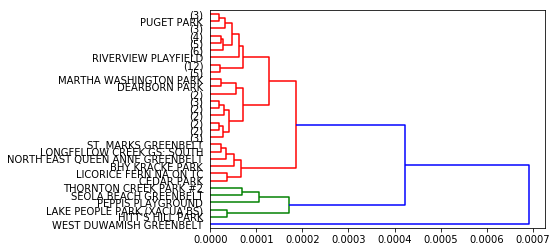

In [58]:
# agglomerative hierarchical clustering using 'complete' method
dend_park2 = dendrogram(linkage(D_park1, method = 'complete'),
                  labels = D_park1.columns,
                  leaf_font_size=10,
                  truncate_mode='lastp',
                  orientation='right',
                  color_threshold=0.000269)

### Visualizaing Features on Maps

In [59]:
# save the park name into a variable
parks = np.array(trails4.index)

# read-in park location text file
park_geoc = pd.read_csv('park_geoc.txt', sep = " ")

In [60]:
# column bind park names and all corresponding feature values
parkntrail = pd.concat([pd.Series(parks), park_geoc.reset_index(drop=True),trails4.reset_index(drop=True)], axis=1 )
parkntrail.rename(columns={parkntrail.columns[0]: "Park_name"})

,Park_name,lon,lat,SURFACE_TY,CONDITION,WIDTH,CANOPY,GRADE_TYPE,GRADE_PERC,TOT_LENG
0,BHY KRACKE PARK,-122.348660,47.630493,3,4,3,1,3,9,1480.812285
1,BOREN PARK,-122.312620,47.634446,1,1,3,3,4,10,2177.787564
2,CAMP LONG,-122.373195,47.557378,3,1,4,3,2,4,19582.913129
3,CARKEEK PARK,-122.372169,47.711623,3,1,4,3,3,7,34851.762358
4,CEDAR PARK,-122.286436,47.724326,3,4,5,1,1,3,1189.197911
5,CHEASTY GREENSPACE,-122.297090,47.561170,1,4,1,1,3,1,2325.212418
6,CHEASTY GREENSPACE: MT VIEW,-122.297090,47.561170,3,4,3,4,3,5,2068.963958
7,CHEASTY GS: CHEASTY BLVD,-122.304611,47.561300,3,4,3,3,2,7,7175.168143
8,COLMAN PARK,-122.290048,47.586461,3,4,3,1,1,2,9076.014262
9,COWEN PARK,-122.312703,47.672500,3,4,8,1,2,3,3531.929258


In [61]:
# enter google map api key
gmaps.configure(api_key='AI...your API key')
# extract out the latitude and longitude values for all parks
locations = parkntrail[['lat', 'lon']]

**Map by Grade Type**

1 -- flat -- dark green

2 -- gradual -- light green

3 -- moderate -- light orange

4 -- steep -- red

In [62]:
# plot park locations on the map by grade types
# 1 - flat --- 4 - steep (1: dark green, 2: light green, 3: light organge, 4: red)

# extract out the corresponding dataframe for each grade type
grade1 = parkntrail[parkntrail['GRADE_TYPE'] == 1]
grade2 = parkntrail[parkntrail['GRADE_TYPE'] == 2]
grade3 = parkntrail[parkntrail['GRADE_TYPE'] == 3]
grade4 = parkntrail[parkntrail['GRADE_TYPE'] == 4]


# create the map layers for each grade type
layer_grade1 = gmaps.symbol_layer(grade1[['lat','lon']], fill_color = (26,152,80), 
                                  stroke_opacity = 0, fill_opacity = 0.9, scale = 5)
layer_grade2 = gmaps.symbol_layer(grade2[['lat','lon']], fill_color = (166, 217, 106),
                                 stroke_opacity = 0, fill_opacity = 0.9, scale = 5)
layer_grade3 = gmaps.symbol_layer(grade3[['lat','lon']], fill_color = (253, 174, 97),
                                 stroke_opacity = 0, fill_opacity = 0.9, scale = 5)
layer_grade4 = gmaps.symbol_layer(grade4[['lat','lon']], fill_color = (215, 48, 39),
                                 stroke_opacity = 0, fill_opacity = 0.9, scale = 5)

In [63]:
# show all the map layers
fig_grade = gmaps.figure()
fig_grade.add_layer(layer_grade1)
fig_grade.add_layer(layer_grade2)
fig_grade.add_layer(layer_grade3)
fig_grade.add_layer(layer_grade4)
fig_grade

Figure(layout=FigureLayout(height='420px'))

**Map by Surface Type**

1 -- soft surface, low level of human impact -- blue (32,159,255)

2 -- moderate hardness, moderate level of human impact -- light orange (255,191,0)

3 -- hard surface, high level of human impact -- red (255,0,0)


In [64]:
# extract out the corresponding dataframe for each surface type
surface1 = parkntrail[parkntrail['SURFACE_TY'] == 1]
surface2 = parkntrail[parkntrail['SURFACE_TY'] == 2]
surface3 = parkntrail[parkntrail['SURFACE_TY'] == 3]

# create the map layers for each surface type
layer_surface1 = gmaps.symbol_layer(surface1[['lat','lon']], fill_color = (32,159,255), 
                                  stroke_opacity = 0, fill_opacity = 0.8, scale = 5)
layer_surface2 = gmaps.symbol_layer(surface2[['lat','lon']], fill_color = (255,191,0),
                                 stroke_opacity = 0, fill_opacity = 1, scale = 5)
layer_surface3 = gmaps.symbol_layer(surface3[['lat','lon']], fill_color = (255,0,0),
                                 stroke_opacity = 0, fill_opacity = 0.8, scale = 5)


In [65]:
# show all the map layers
fig_surf = gmaps.figure()
fig_surf.add_layer(layer_surface2)
fig_surf.add_layer(layer_surface1)
fig_surf.add_layer(layer_surface3)
fig_surf

Figure(layout=FigureLayout(height='420px'))

**Map by Width** : 

width range 0-2: scale 3

width range 3-4: scale 4

width range 5-9: scale 6

width range 10+: scale 7

In [66]:
# extract out the trail width
width = parkntrail['WIDTH']

# initialize an array to store the width group values for each park
width_group = np.zeros(len(width))
# populate the width group array 
for i in range(len(width)):
    if width[i] in range(0,3):
        width_group[i] = 3
    elif width[i] in range(3,5):
        width_group[i] = 4
    elif width[i] in range(5,10):
        width_group[i] = 6
    else:
        width_group[i] = 7

In [67]:
# column bind the width group with the original data frame with location info
parkntrail = pd.concat([parkntrail.reset_index(drop=True),
             pd.Series(width_group).rename('width_group').reset_index(drop=True)], axis=1 )

In [68]:
# extract out the corresponding dataframe for each width group
widg3 = parkntrail[parkntrail['width_group'] == 3]
widg4 = parkntrail[parkntrail['width_group'] == 4]
widg6 = parkntrail[parkntrail['width_group'] == 6]
widg7 = parkntrail[parkntrail['width_group'] == 7]

# create the map layers for each width group
layer_widg3 = gmaps.symbol_layer(widg3[['lat','lon']], fill_color = (69,117,180), 
                                  stroke_opacity = 0, fill_opacity = 0.7, scale = 3)
layer_widg4 = gmaps.symbol_layer(widg4[['lat','lon']], fill_color = (69,117,180),
                                 stroke_opacity = 0, fill_opacity = 0.7, scale = 4)
layer_widg6 = gmaps.symbol_layer(widg6[['lat','lon']], fill_color = (69,117,180),
                                 stroke_opacity = 0, fill_opacity = 0.7, scale = 6)
layer_widg7 = gmaps.symbol_layer(widg7[['lat','lon']], fill_color = (69,117,180),
                                 stroke_opacity = 0, fill_opacity = 0.7, scale = 7)


In [69]:
# show all the map layers
fig_widg = gmaps.figure()
fig_widg.add_layer(layer_widg3)
fig_widg.add_layer(layer_widg4)
fig_widg.add_layer(layer_widg6)
fig_widg.add_layer(layer_widg7)
fig_widg

Figure(layout=FigureLayout(height='420px'))

**Map by Tree Canopy Coverage Rate**

Open -- 1 -- dark pink (197,27,125)

Low -- 2 -- light pink (241,182,218)

High -- 3 -- light green (184,225,134)

Closed -- 4 -- dark green (77,146,33)

In [70]:
# extract out the corresponding dataframe for each tree canopy coverage rate
canopy1 = parkntrail[parkntrail['CANOPY'] == 1]
canopy2 = parkntrail[parkntrail['CANOPY'] == 2]
canopy3 = parkntrail[parkntrail['CANOPY'] == 3]
canopy4 = parkntrail[parkntrail['CANOPY'] == 4]


# create the map layers for each canopy coverage rate
layer_canopy1 = gmaps.symbol_layer(canopy1[['lat','lon']], fill_color = (197,27,125), 
                                  stroke_opacity = 0, fill_opacity = 0.9, scale = 5)
layer_canopy2 = gmaps.symbol_layer(canopy2[['lat','lon']], fill_color = (241,182,218),
                                 stroke_opacity = 0, fill_opacity = 0.9, scale = 5)
layer_canopy3 = gmaps.symbol_layer(canopy3[['lat','lon']], fill_color = (184,225,134),
                                 stroke_opacity = 0, fill_opacity = 0.99, scale = 5)
layer_canopy4 = gmaps.symbol_layer(canopy4[['lat','lon']], fill_color = (77,146,33),
                                 stroke_opacity = 0, fill_opacity = 1, scale = 5)

In [71]:
# show all the map layers
fig_canopy = gmaps.figure()
fig_canopy.add_layer(layer_canopy1)
fig_canopy.add_layer(layer_canopy2)
fig_canopy.add_layer(layer_canopy3)
fig_canopy.add_layer(layer_canopy4)
fig_canopy

Figure(layout=FigureLayout(height='420px'))

**Map by Condition**

Worn and eroded -- 1 -- red (237,3,69)

Poor -- 2 -- orange (244,163,46)

Good -- 4 -- cyan (10,130,124)

In [72]:
# extract out the corresponding dataframe for each condition level
condition1 = parkntrail[parkntrail['CONDITION'] == 1]
condition2 = parkntrail[parkntrail['CONDITION'] == 2]
condition4 = parkntrail[parkntrail['CONDITION'] == 4]

# create the map layers for each condition level
layer_cond1 = gmaps.symbol_layer(condition1[['lat','lon']], fill_color = (237,3,69), 
                                  stroke_opacity = 0, fill_opacity = 0.9, scale = 5)
layer_cond2 = gmaps.symbol_layer(condition2[['lat','lon']], fill_color = (244,163,46),
                                 stroke_opacity = 0, fill_opacity = 0.9, scale = 5)
layer_cond4 = gmaps.symbol_layer(condition4[['lat','lon']], fill_color = (10,130,124),
                                 stroke_opacity = 0, fill_opacity = 0.8, scale = 5)

In [73]:
# show all the map layers
fig_cond = gmaps.figure()
fig_cond.add_layer(layer_cond1)
fig_cond.add_layer(layer_cond2)
fig_cond.add_layer(layer_cond4)
fig_cond

Figure(layout=FigureLayout(height='420px'))